### Importanto bibliotecas 

In [66]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

#Modelo
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.tsa.stattools import adfuller #teste de dicky fuller

plt.rcParams['figure.figsize'] = 20,10

#### Importanto Ativos



In [5]:
acao = 'PETR4.SA'


In [6]:
df = yf.download(acao, start='2009-12-01', end='2023-01-01',interval='1mo' )['Adj Close']
df.head(5)

[*********************100%***********************]  1 of 1 completed


Date
2009-12-01    11.285083
2009-12-21          NaN
2010-01-01    10.567767
2010-02-01    10.703844
2010-03-01    10.945074
Name: Adj Close, dtype: float64

## Tratando dados

In [7]:
df = df.to_frame()
df = df.rename(columns={'Adj Close':'PETR4.SA'})
df.head()

,PETR4.SA
Date,
2009-12-01,11.285083
2009-12-21,NaN
2010-01-01,10.567767
2010-02-01,10.703844
2010-03-01,10.945074


In [8]:
df.isna().sum()

PETR4.SA    35
dtype: int64

In [9]:
df.dropna(inplace=True)
df.isna().sum()

PETR4.SA    0
dtype: int64

In [10]:
df= df.reset_index()
df.dtypes

Date        datetime64[ns]
PETR4.SA           float64
dtype: object

## Estatísticas 

In [11]:
df.describe()

,PETR4.SA
count,157.000000
mean,8.136600
std,3.871336
min,1.781554
25%,5.625491
50%,7.273243
75%,9.879709
max,21.786951


## Autocorrelação da Série temporal

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

def acf (series):
    plot_acf(series)


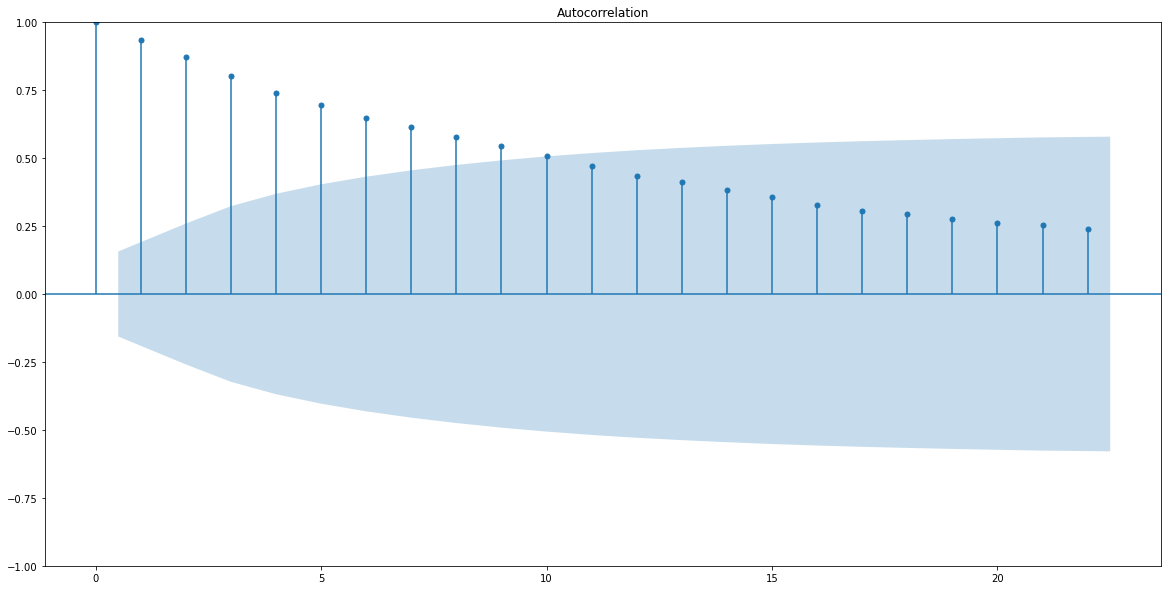

In [13]:
acf(df['PETR4.SA'])

In [14]:
abev_analysis = df.copy()

abev_analysis.head(5)

,Date,PETR4.SA
0,2009-12-01,11.285083
1,2010-01-01,10.567767
2,2010-02-01,10.703844
3,2010-03-01,10.945074
4,2010-04-01,10.144063


In [15]:
abev_analysis['Date']

0     2009-12-01
1     2010-01-01
2     2010-02-01
3     2010-03-01
4     2010-04-01
         ...    
152   2022-08-01
153   2022-09-01
154   2022-10-01
155   2022-11-01
156   2022-12-01
Name: Date, Length: 157, dtype: datetime64[ns]

In [16]:
start_date = '2010-01-01'
end_date = '2022-12-01'
xcoords = pd.date_range(start=start_date, end=end_date, freq='A')

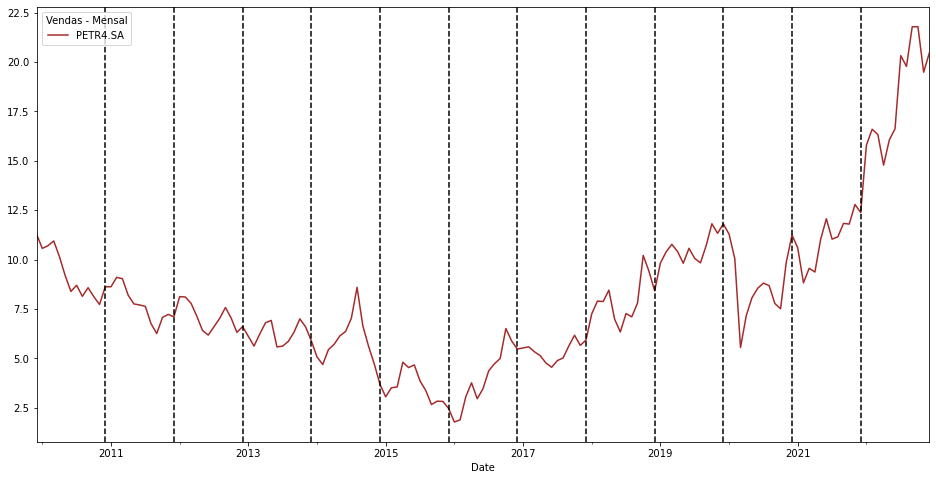

In [17]:

ax = abev_analysis.plot(x='Date', y='PETR4.SA', figsize=(16,8), color='brown', legend=False)
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.legend(title = 'Vendas - Mensal')
plt.show()



### BBAS3

## Decompondo a série

In [19]:
def decompose(acao):
    result = sm.tsa.seasonal_decompose(acao, model='multiplicative')

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid


    fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,9))
    result.observed.plot(ax=ax1, color='brown',ylabel='Observação', xlabel=' ',legend=False)
    ax1.axes.xaxis.set_visible(False)
    result.trend.plot(ax=ax2,color='brown',ylabel='Tendência',xlabel=' ',legend=False)
    ax2.axes.xaxis.set_visible(False)
    result.seasonal.plot(ax=ax3,color='brown', ylabel='Sazonal',xlabel=' ',legend=False)
    ax3.axes.xaxis.set_visible(False)
    result.resid.plot(ax=ax4,color='brown',ylabel='Residual',legend=False)
    plt.savefig("teste_sazonalidade_mensal.png",dpi=300)
    plt.show()

#### ABEV3.SA	BBAS3.SA	GGBR4.SA	PETR4.SA	VALE3.SA	WEGE3.SA

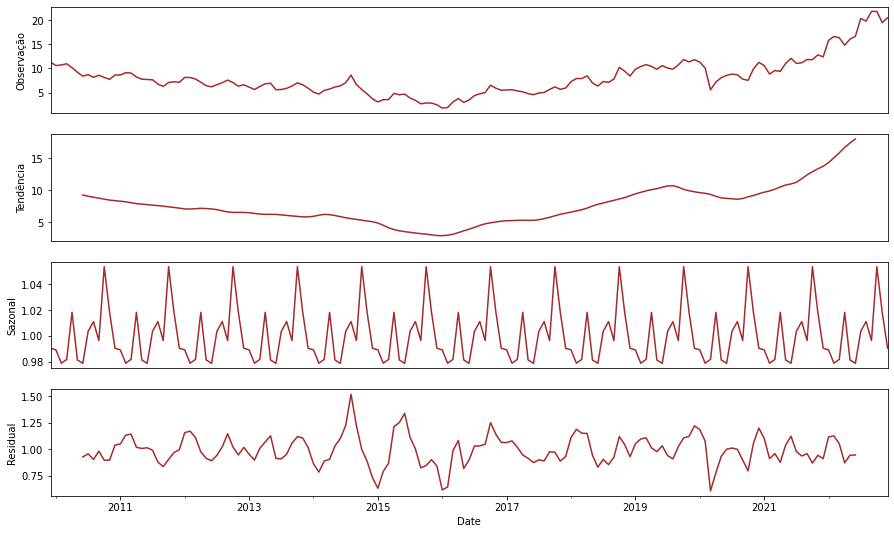

In [20]:
#PETR4

PETR4 = df.copy()

PETR4.set_index('Date', inplace=True)


decompose(PETR4)


## Tratando outliers

In [21]:
def remove_outlier(dados):

    quartil1 = dados.quantile(0.25)
    quartil3 = dados.quantile(0.75)

    interQuartil = quartil3 - quartil1

    limiteSuperior = quartil1 -(1.5* interQuartil) 
    limiteInferior = quartil3 - (1.5 * interQuartil)



    dados_final = dados.apply(lambda x: x if (x> limiteInferior) or (x< limiteSuperior) else dados.mean())
    
    return dados_final



In [27]:
df_tratado = pd.DataFrame()
for cols in df.columns:
 
    df_tratado['PETR4.SA'] = remove_outlier(PETR4['PETR4.SA'])


df_tratado.head(5)

,PETR4.SA
Date,
2009-12-01,11.285083
2010-01-01,10.567767
2010-02-01,10.703844
2010-03-01,10.945074
2010-04-01,10.144063


<AxesSubplot:>

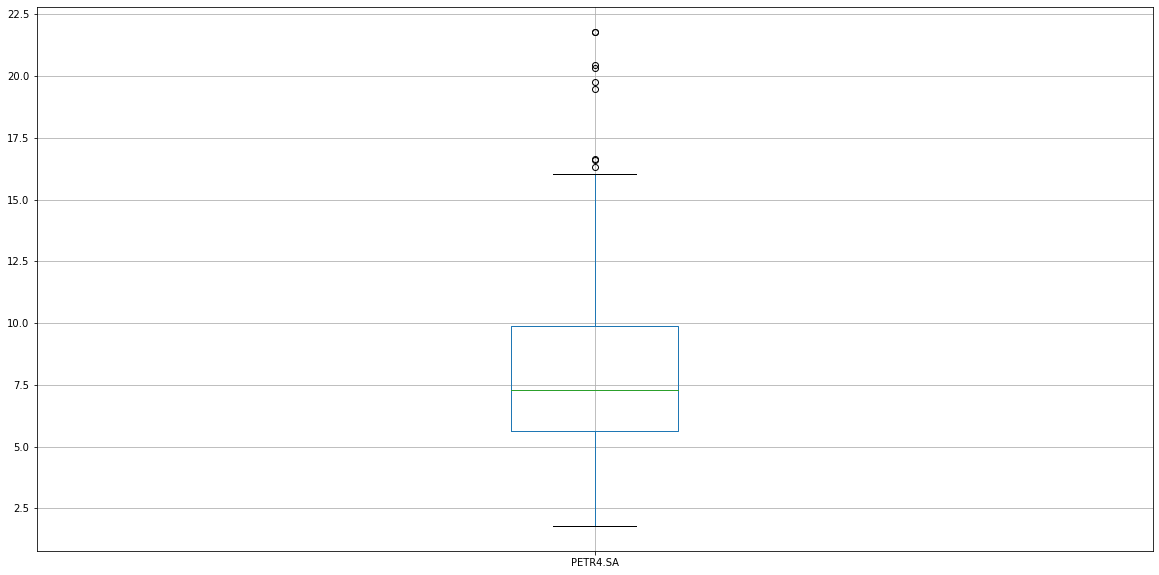

In [28]:
df.boxplot()

<AxesSubplot:>

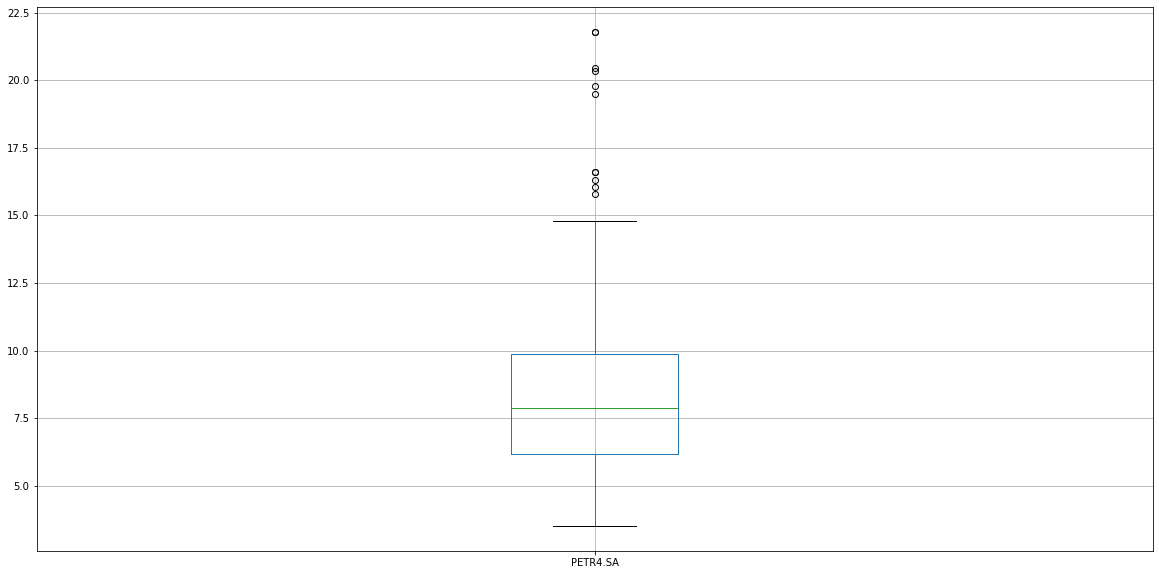

In [29]:

df_tratado.boxplot()


In [30]:
df_tratado.head(5)

,PETR4.SA
Date,
2009-12-01,11.285083
2010-01-01,10.567767
2010-02-01,10.703844
2010-03-01,10.945074
2010-04-01,10.144063


# Transformando em série estacionária 

In [31]:
from statsmodels.tsa.stattools import adfuller #teste de dicky fuller

#Teste de estacionariedade Dickey Fuller

def adf_test(dados):
    print('Resultado do Teste Dickey-Fuller:')
    adftest = adfuller(dados, autolag = 'AIC') # Faz o teste de Dickey Fuller e obtem a metrica de avalição AIC -> AKAIKE INFORMATION CRITERION
    output = pd.Series(adftest[0:4], index=['Teste', 'Valor de P', 'Numeros de lags', 'Numeros de observações']) # atribue titulo as series
    for key, value in adftest[4].items():
        output['Valor Crítico ({})'.format(key)] = value
    print(output)

# Transformando em Estacionária 
def diff(dados):
    diff_dados = dados.pct_change()
    diff_dados.dropna(inplace=True)
    return diff_dados




In [32]:
diff_petr = diff(df_tratado)


adf_test(diff_petr)

Resultado do Teste Dickey-Fuller:
Teste                      -3.503702
Valor de P                  0.007893
Numeros de lags             8.000000
Numeros de observações    147.000000
Valor Crítico (1%)         -3.475637
Valor Crítico (5%)         -2.881410
Valor Crítico (10%)        -2.577365
dtype: float64


### Projeção - Escolhendo os atributos do modelo

In [33]:
df.set_index('Date')
analysis = df.copy()
analysis.dtypes

Date        datetime64[ns]
PETR4.SA           float64
dtype: object

#### TESTE

In [35]:

# #Find minimal AIC value for the SARIMA model integers



# p = range(0,2)
# d = range(0,2)
# q = range(0,2)

# pdq = list(itertools.product(p,d,q))

# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

# warnings.filterwarnings("ignore")

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#             mod = sm.tsa.statespace.SARIMAX(diff_petr['PETR4.SA'],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()
#             print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

      

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-43.82928555030286
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-27.82258131240691
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:66.39169060423858
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-2.778117825496274
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-29.051111598923512
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-25.825431593438253
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:40.132522010323505
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3.6930165971414084
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-55.9413122968988
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-39.23886691436061
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:49.14187459723007
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-14.431854612933293
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-41.89200239193509
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-37.29376615764491
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:25.966310160601342
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-9.302117648073711
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:98.42099690279655
SARIMAX(0, 1, 0

In [ ]:
model_abev = auto_arima(df_tratado['PETR4.SA'], start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                        suppress_warnings = True, stepwise=False)

## Aplicando o modelo estatistico 

In [37]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [36]:
PETR4= PETR4.asfreq('MS')


In [39]:
list_param = []
list_param_seasonal = []
list_results_aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff_petr,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-43.82928555030286
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-27.82258131240691
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:66.39169060423858
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-2.778117825496274
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-29.051111598923512
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-25.825431593438253
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:40.132522010323505
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3.6930165971414084
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-55.9413122968988
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-39.23886691436061
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:49.14187459723007
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-14.431854612933293
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-41.89200239193509
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-37.29376615764491
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:25.966310160601342
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-9.302117648073711
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:98.42099690279655
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 

In [41]:
aic_petr= pd.DataFrame({'{}':list_param,'{}12':list_param_seasonal, 'AIC':list_results_aic}).sort_values(by='AIC')

In [43]:
aic_petr.max()

{}          (1, 1, 1)
{}12    (1, 1, 1, 12)
AIC        197.245914
dtype: object

In [44]:
mod = sm.tsa.statespace.SARIMAX(diff_petr.astype(float),
                                order= (1, 1, 1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2592      0.079     -3.296      0.001      -0.413      -0.105
ma.L1         -1.0000     88.086     -0.011      0.991    -173.646     171.646
ar.S.L12      -0.0868      0.103     -0.841      0.400      -0.289       0.116
ma.S.L12      -1.0000    853.669     -0.001      0.999   -1674.160    1672.160
sigma2         0.0434     37.424      0.001      0.999     -73.305      73.392


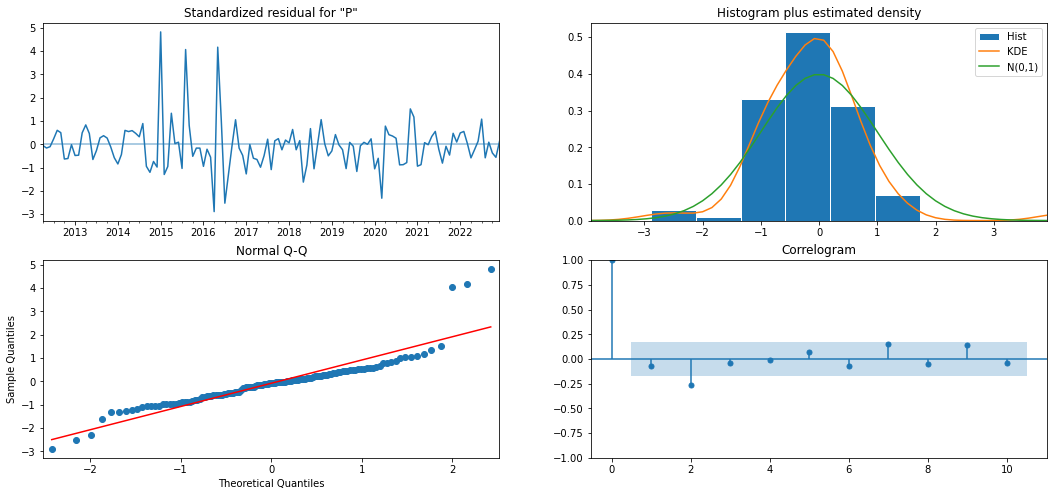

In [45]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

**Os gráficos residuais para o modelo automático SARIMA parecem muito bons.**

* **Histograma mais gráfico de densidade estimada:** A linha  KDE segue de perto com a linha N(0,1). Esta é uma boa indicação de que os resíduos são normalmente distribuídos.

* **O QQ-plot:** Mostra que a distribuição ordenada dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). Esta é uma indicação de que os resíduos são normalmente distribuídos.

* **O gráfico de resíduos padronizados:** Os resíduos ao longo do tempo não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

* **O gráfico do Correlograma:** Mostra que os resíduos da série temporal têm baixa correlação com as versões defasadas de si mesmo.  A distribuição e a função de Auto correlação ACF (correlograma). Valores acima do “0” têm alguma correlação com os dados da série temporal. Valores próximos a “1” demonstram a correlação mais forte


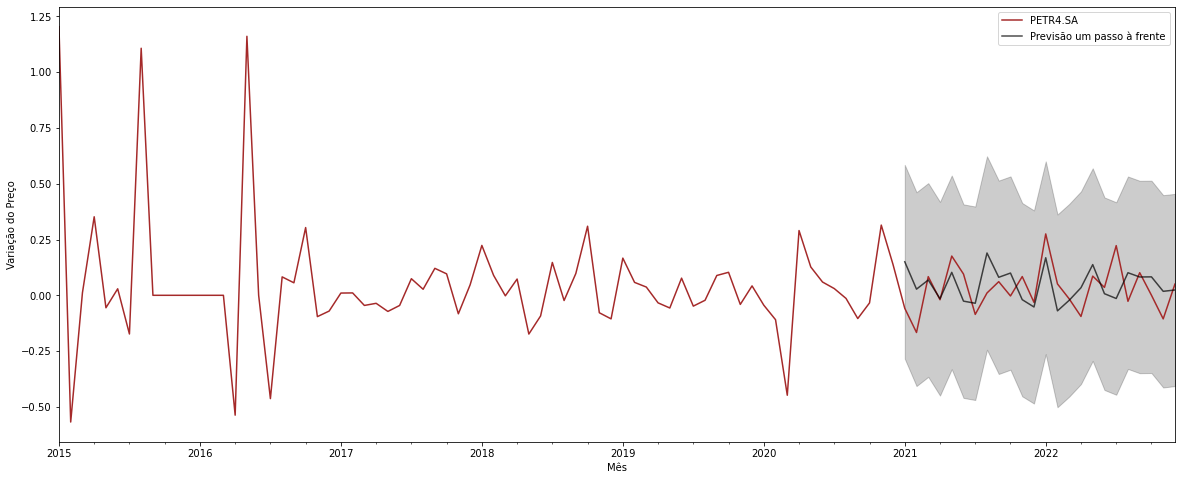

In [46]:
# Treino do Modelo para Previsão
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = diff_petr['2015':].plot(label='observed', color='brown')
pred.predicted_mean.plot(ax=ax, label='Previsão um passo à frente', alpha=.7, figsize=(20, 8), color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Variação do Preço')
plt.legend()
plt.xlabel('Mês')
# plt.savefig("vendas_sarimax.png",dpi=300)
plt.show()

In [48]:
# Cálculo do Erro
y_forecasted = pred.predicted_mean
y_truth = diff_petr['PETR4.SA']['2021-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('====================================================')
print('O erro quadrático médio é {}'.format(round(mse, 2)))
print('A raiz do erro quadrático médio é {}'.format(round(np.sqrt(mse), 2)))
print('====================================================')

O erro quadrático médio é 0.01
A raiz do erro quadrático médio é 0.11


## PREVISÃO DOS PROXIMOS 6 MESES

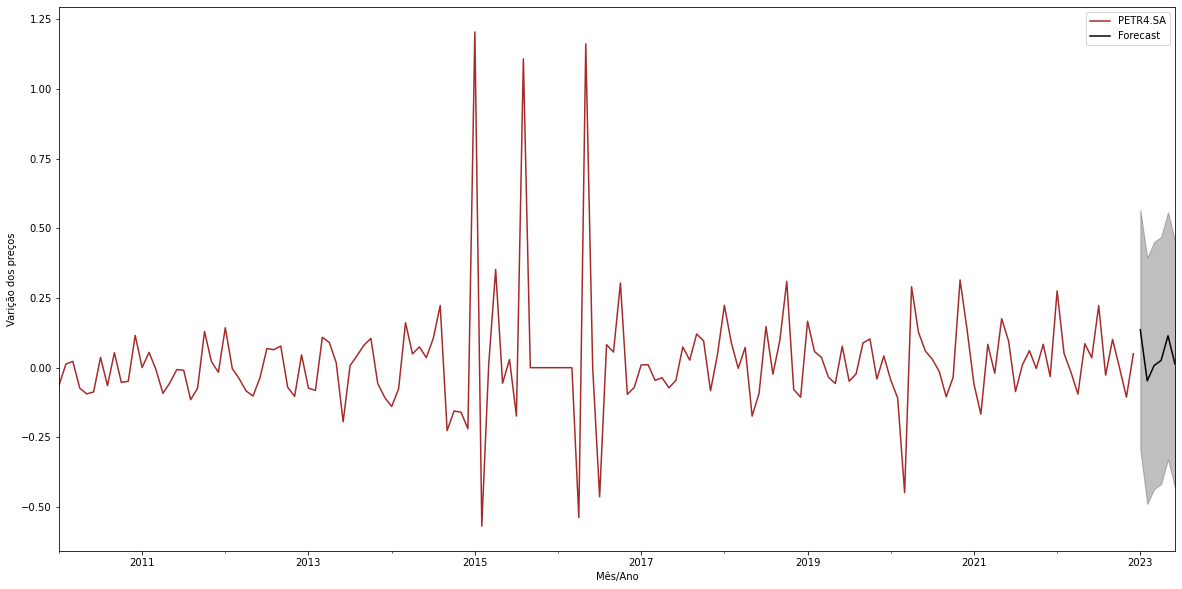

In [50]:
# Previsão para os próximos meses
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = diff_petr.plot(label='Variacao do preço', color='brown')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Varição dos preços')
ax.legend(['variação conhecida','Forecast'])
plt.xlabel('Mês/Ano')
# plt.savefig("forecast.png",dpi=150)
plt.legend()
plt.show()

In [58]:
forecast = pred_ci
forecast['Forecast'] = pred_uc.predicted_mean
forecast.astype(float)

,lower PETR4.SA,upper PETR4.SA,Forecast
2023-01-01,-0.293666,0.566236,0.136285
2023-02-01,-0.489051,0.394720,-0.047165
2023-03-01,-0.435502,0.450977,0.007738
2023-04-01,-0.417274,0.469094,0.025910
2023-05-01,-0.328825,0.557612,0.114393
2023-06-01,-0.429909,0.456513,0.013302


In [59]:

predictions_pct = pd.DataFrame(forecast, columns={'lower PETR4.SA',	'upper PETR4.SA',	'Forecast','lower price', 'upper price', 'price'}).copy()
previous_price = PETR4['PETR4.SA'].iloc[-1]


for i in range(len(predictions_pct)): 
    predictions_pct['price'][i] = previous_price * (1  +  (predictions_pct['Forecast'][i]))
    predictions_pct['lower price'][i] = previous_price * (1  +  (predictions_pct['lower PETR4.SA'][i]))
    predictions_pct['upper price'][i] = previous_price * (1  +  (predictions_pct['upper PETR4.SA'][i]))
    # print(predictions_pct['price'][i] ,' preço:', previous_price, 'variacao',predictions_pct['Forecast'][i] )
    previous_price = predictions_pct['price'][i]

# Exibindo as previsões dos preços
predictions_pct

,lower PETR4.SA,price,upper price,lower price,Forecast,upper PETR4.SA
2023-01-01,-0.293666,23.254428,32.053506,14.455350,0.136285,0.566236
2023-02-01,-0.489051,22.157625,32.433413,11.881837,-0.047165,0.394720
2023-03-01,-0.435502,22.329077,32.150208,12.507946,0.007738,0.450977
2023-04-01,-0.417274,22.907631,32.803522,13.011739,0.025910,0.469094
2023-05-01,-0.328825,25.528114,35.681194,15.375035,0.114393,0.557612
2023-06-01,-0.429909,25.867692,37.182025,14.553360,0.013302,0.456513


In [60]:
df_forecast = predictions_pct.reset_index().copy()
df_forecast['mes'] = df_forecast['index'].dt.month
df_forecast['ano'] = df_forecast['index'].dt.year
df_forecast['Trimestre'] = df_forecast['mes'].apply(lambda x: '1º Trismestre' if x>8 else ('2º Trimestre' if (x>4 and x< 9) else '1º Trimestre'))
df_forecast

,index,lower PETR4.SA,price,upper price,lower price,Forecast,upper PETR4.SA,mes,ano,Trimestre
0,2023-01-01,-0.293666,23.254428,32.053506,14.455350,0.136285,0.566236,1,2023,1º Trimestre
1,2023-02-01,-0.489051,22.157625,32.433413,11.881837,-0.047165,0.394720,2,2023,1º Trimestre
2,2023-03-01,-0.435502,22.329077,32.150208,12.507946,0.007738,0.450977,3,2023,1º Trimestre
3,2023-04-01,-0.417274,22.907631,32.803522,13.011739,0.025910,0.469094,4,2023,1º Trimestre
4,2023-05-01,-0.328825,25.528114,35.681194,15.375035,0.114393,0.557612,5,2023,2º Trimestre
5,2023-06-01,-0.429909,25.867692,37.182025,14.553360,0.013302,0.456513,6,2023,2º Trimestre


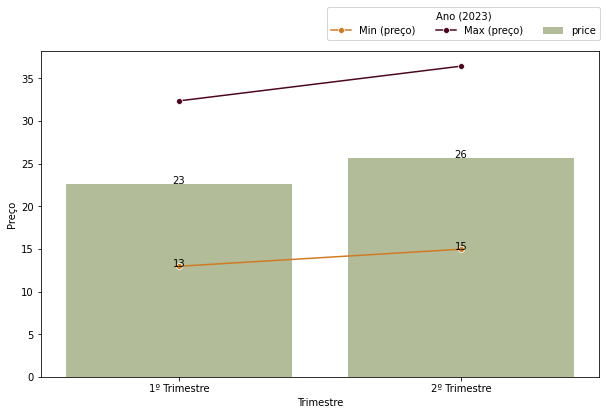

<Figure size 1440x720 with 0 Axes>

In [61]:
#palette=['#4c061d','#d17a22', '#b4c292'])#

df_aux = df_forecast[df_forecast['ano']==2023].groupby(['Trimestre','ano']).agg({'price':'mean',
                                                                                    'lower price':'mean',
                                                                                    'upper price':'mean'}).reset_index()
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x='Trimestre', y='price',
                 data=df_aux, palette=['#b4c292'], label='price') 

ax = sns.barplot(x='Trimestre', y='lower price',
                 data=df_aux, palette=['#b4c292'], alpha=0) 

# ax = sns.barplot(x='quadrimestre', y='upper price',
#                  data=df_aux, palette=['#b4c292'], alpha=0) 

ax = sns.lineplot(x='Trimestre', y='lower price',label='Min (preço)',
                 data=df_aux, color='#d17a22',marker='o') 

ax = sns.lineplot(x='Trimestre', y='upper price',
                 data=df_aux, color='#4c061d',marker='o',label = 'Max (preço)') 

plt.legend(title='Ano (2023)',ncol=3,bbox_to_anchor=(1.01, 1.15))
plt.xlabel('Trimestre')
plt.ylabel('Preço')
for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate('{:.0f}'.format(p.get_height()), (x, y), ha='center')
plt.show()
plt.savefig("preços Trimestre_PETR4.png",dpi=150)



In [62]:
PETR4

,PETR4.SA
Date,
2009-12-01,11.285083
2010-01-01,10.567767
2010-02-01,10.703844
2010-03-01,10.945074
2010-04-01,10.144063
...,...
2022-08-01,19.776236
2022-09-01,21.779640
2022-10-01,21.786951


In [63]:
df_forecast = df_forecast.set_index('index')
pred_petr = pd.DataFrame()
pred_petr['price'] = PETR4['PETR4.SA'].append(df_forecast['price'], ignore_index=True)
pred_petr['Date'] = PETR4.index.append(df_forecast.index)
pred_petr = pred_petr.set_index('Date')
pred_petr

,price
Date,
2009-12-01,11.285083
2010-01-01,10.567767
2010-02-01,10.703844
2010-03-01,10.945074
2010-04-01,10.144063
...,...
2023-02-01,22.157625
2023-03-01,22.329077
2023-04-01,22.907631


<AxesSubplot:xlabel='Date'>

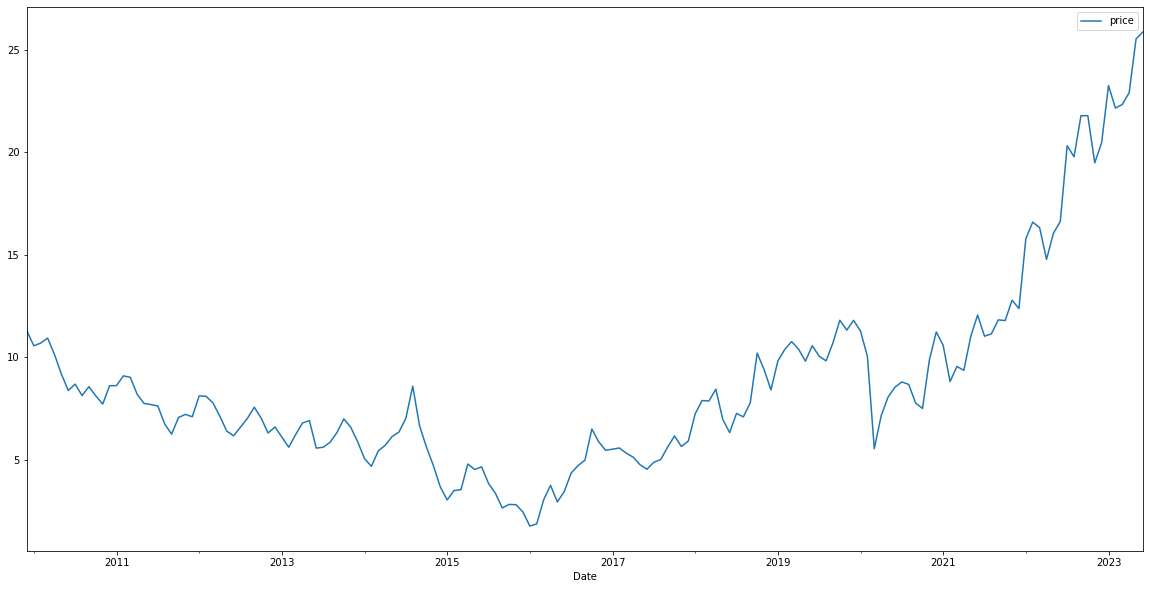

In [65]:
pred_petr.plot()